# Chapter 9: Hyper-Parameter Tuning with Cross-Validation

This notebook demonstrates hyperparameter optimization (HPO) techniques from **Advances in Financial Machine Learning** (AFML) Chapter 9.

## Why HPO Matters in Finance

Hyper-parameter tuning is essential for fitting ML algorithms properly. When not done correctly:
- The algorithm is likely to **overfit**
- Live performance will **disappoint**
- Your strategy will fail in production

## The Critical Problem

Standard cross-validation methods from other fields **fail in finance** because:
1. Financial observations are **not IID** (independent and identically distributed)
2. Labels often **overlap in time** (e.g., 10-day forward returns)
3. Standard CV causes **information leakage** during hyperparameter search

## The Solution: Purged K-Fold CV

We use **Purged K-Fold Cross-Validation** (from Chapter 7) for HPO to:
- Remove training observations that overlap with test labels
- Apply an embargo period after each test set
- Prevent the search from overfitting to leaked information

## Table of Contents

1. [Setup and Synthetic Data](#1.-Setup-and-Synthetic-Data)
2. [Grid Search with Purged CV](#2.-Grid-Search-with-Purged-CV)
3. [Log-Uniform Distribution](#3.-Log-Uniform-Distribution)
4. [Randomized Search with Purged CV](#4.-Randomized-Search-with-Purged-CV)
5. [Scoring Metrics: Why neg_log_loss?](#5.-Scoring-Metrics:-Why-neg_log_loss?)
6. [Sample Weight Pipeline](#6.-Sample-Weight-Pipeline)
7. [Comparing Search Methods](#7.-Comparing-Search-Methods)
8. [Best Practices](#8.-Best-Practices)

---

## 1. Setup and Synthetic Data

In [1]:
# Add project root to path
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, f1_score
import time
import warnings
warnings.filterwarnings('ignore')

# AFML HPO module
from afml.hpo import (
    log_uniform,
    int_log_uniform,
    LogUniformDistribution,
    SampleWeightPipeline,
    create_pipeline_with_estimator,
    fit_hyperparameters,
    grid_search_cv,
    randomized_search_cv,
    select_scoring_metric,
    get_cv_results_dataframe,
)

# AFML Cross-validation module
from afml.cross_validation import PurgedKFold

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Random seed
np.random.seed(42)

print("Setup complete!")

Setup complete!


### Generate Synthetic Financial Data

We create a synthetic dataset with:
- **Overlapping labels**: Each observation's label spans multiple days
- **Time-indexed data**: Simulating financial time series
- **Known structure**: 5 informative features, 5 noise features

In [2]:
# Generate synthetic classification data
n_samples = 2000
n_features = 10
n_informative = 5

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=0,
    random_state=42,
    shuffle=False,
)

# Create time index (business days)
date_index = pd.date_range('2015-01-01', periods=n_samples, freq='B')

# Create DataFrame
X = pd.DataFrame(X, index=date_index, columns=[f'feature_{i}' for i in range(n_features)])

# Create label times (each label spans 10 days into the future)
# This simulates, e.g., 10-day forward returns
label_span_days = 10
label_times = pd.Series(
    index=date_index,
    data=date_index + pd.Timedelta(days=label_span_days)
)

print("Synthetic Financial Dataset")
print("="*50)
print(f"Samples: {n_samples}")
print(f"Features: {n_features} ({n_informative} informative)")
print(f"Date range: {date_index[0].date()} to {date_index[-1].date()}")
print(f"Label span: {label_span_days} days")
print(f"\nLabel distribution: {np.bincount(y)}")
print(f"\nFirst few observations:")
print(X.head())

Synthetic Financial Dataset
Samples: 2000
Features: 10 (5 informative)
Date range: 2015-01-01 to 2022-08-31
Label span: 10 days

Label distribution: [ 998 1002]

First few observations:
            feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
2015-01-01   0.642928  -0.621520   2.663515  -0.599783   0.335670   0.983736   
2015-01-02  -0.070846   2.901385  -0.832169  -1.501497  -0.212647  -0.586412   
2015-01-05   0.876182   2.158993   1.566156  -1.121890  -0.151822   0.025114   
2015-01-06   1.279393   0.256761   1.444611  -0.827628   1.100561   1.152888   
2015-01-07   2.664890   3.098181   1.597028  -0.673973   0.122929  -0.296602   

            feature_6  feature_7  feature_8  feature_9  
2015-01-01  -0.232910  -2.060199   0.341922   0.602900  
2015-01-02  -0.579062   2.257856  -0.658214  -1.121881  
2015-01-05   0.574842   0.532434  -2.468068  -0.660732  
2015-01-06   0.326689  -1.235791   1.242409   0.964898  
2015-01-07   0.879467   1.999756  -1.054380   0.

### Visualize Label Overlap

The key challenge: each observation's label extends into the future, causing overlap.

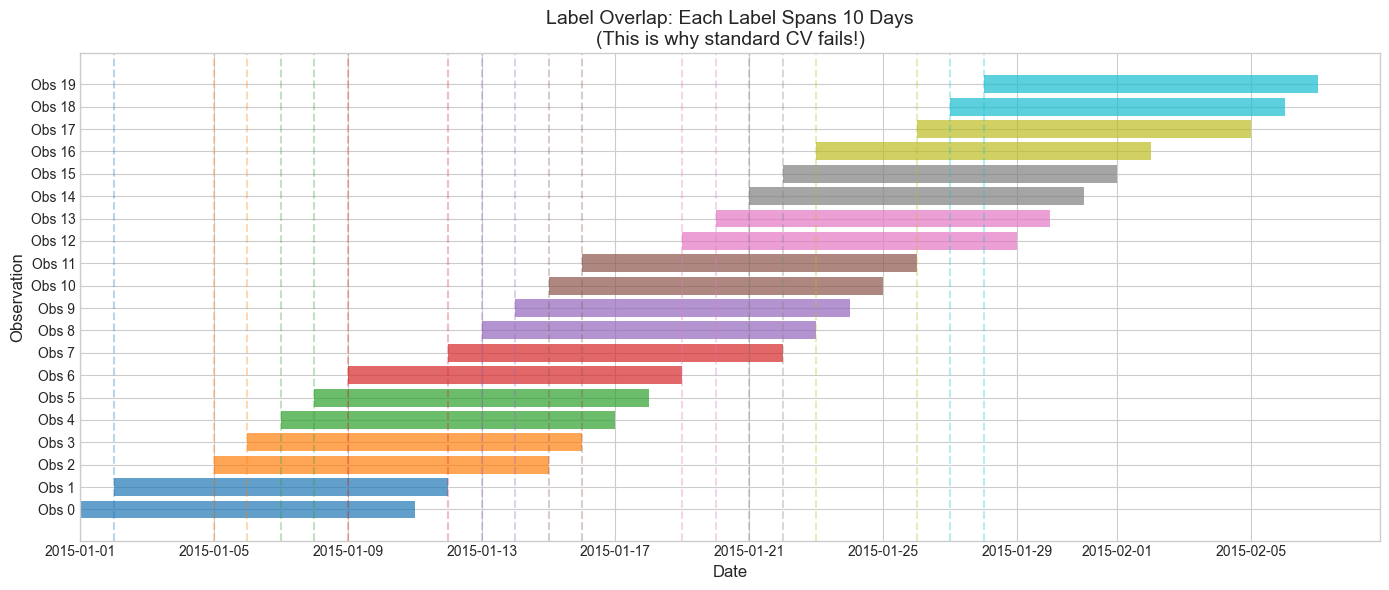

Notice: Observation 0's label overlaps with observations 1-9.
If obs 0 is in test set, obs 1-9 must be purged from training!


In [3]:
# Visualize label overlap for first 20 observations
fig, ax = plt.subplots(figsize=(14, 6))

n_show = 20
colors = plt.cm.tab10(np.linspace(0, 1, n_show))

for i in range(n_show):
    start = label_times.index[i]
    end = label_times.iloc[i]
    ax.barh(i, (end - start).days, left=start, color=colors[i], alpha=0.7, height=0.8)
    ax.axvline(x=start, color=colors[i], linestyle='--', alpha=0.3)

ax.set_yticks(range(n_show))
ax.set_yticklabels([f'Obs {i}' for i in range(n_show)])
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Observation', fontsize=12)
ax.set_title(f'Label Overlap: Each Label Spans {label_span_days} Days\n(This is why standard CV fails!)', fontsize=14)

plt.tight_layout()
plt.show()

print("Notice: Observation 0's label overlaps with observations 1-9.")
print("If obs 0 is in test set, obs 1-9 must be purged from training!")

## 2. Grid Search with Purged CV

### Standard Grid Search vs Purged Grid Search

| Aspect | Standard GridSearchCV | Purged GridSearchCV |
|--------|----------------------|--------------------|
| CV Method | KFold (random splits) | PurgedKFold (temporal, with purging) |
| Leakage | Yes (overlapping labels) | No (purged + embargoed) |
| Result | Overly optimistic scores | Realistic scores |
| Production | Will disappoint | More reliable |

### How Purged Grid Search Works

1. Create a grid of all parameter combinations
2. For each combination:
   - Perform Purged K-Fold CV
   - Compute mean CV score
3. Select the combination with best mean score
4. Refit on all data with best parameters

In [4]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
}

# Count grid size
grid_size = 1
for values in param_grid_rf.values():
    grid_size *= len(values)

print("Grid Search Configuration")
print("="*50)
print(f"Estimator: RandomForestClassifier")
print(f"\nParameter Grid:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {grid_size}")
print(f"CV folds: 5")
print(f"Total fits: {grid_size * 5}")

Grid Search Configuration
Estimator: RandomForestClassifier

Parameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 10, None]
  min_samples_split: [2, 5, 10]

Total combinations: 36
CV folds: 5
Total fits: 180


In [5]:
# Perform Grid Search with Purged CV
print("Running Grid Search with Purged K-Fold CV...")
print("(This may take a minute)")

start_time = time.time()

best_model, best_params, best_score = grid_search_cv(
    features=X,
    labels=y,
    label_times=label_times,
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    n_splits=5,
    embargo_pct=0.01,  # 1% embargo
    scoring='neg_log_loss',
    n_jobs=-1,
    verbose=0,
)

elapsed_time = time.time() - start_time

print(f"\nGrid Search Complete!")
print("="*50)
print(f"Time elapsed: {elapsed_time:.2f} seconds")
print(f"\nBest Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg_log_loss): {best_score:.4f}")

Running Grid Search with Purged K-Fold CV...
(This may take a minute)



Grid Search Complete!
Time elapsed: 7.92 seconds

Best Parameters:
  max_depth: None
  min_samples_split: 2
  n_estimators: 200

Best CV Score (neg_log_loss): -0.4524


## 3. Log-Uniform Distribution

### The Problem with Uniform Sampling

Many ML hyperparameters (like `C` in SVC or `gamma` in RBF kernel) have effects that are **logarithmic**, not linear:

- Changing `C` from 0.01 to 1 (100x) can have as much effect as changing from 1 to 100 (also 100x)
- But Uniform[0, 100] samples 99% of values > 1!

### The Solution: Log-Uniform Sampling

A random variable X follows a **log-uniform distribution** between a and b if:

$$\log(X) \sim \text{Uniform}(\log(a), \log(b))$$

This ensures **equal probability** for each order of magnitude.

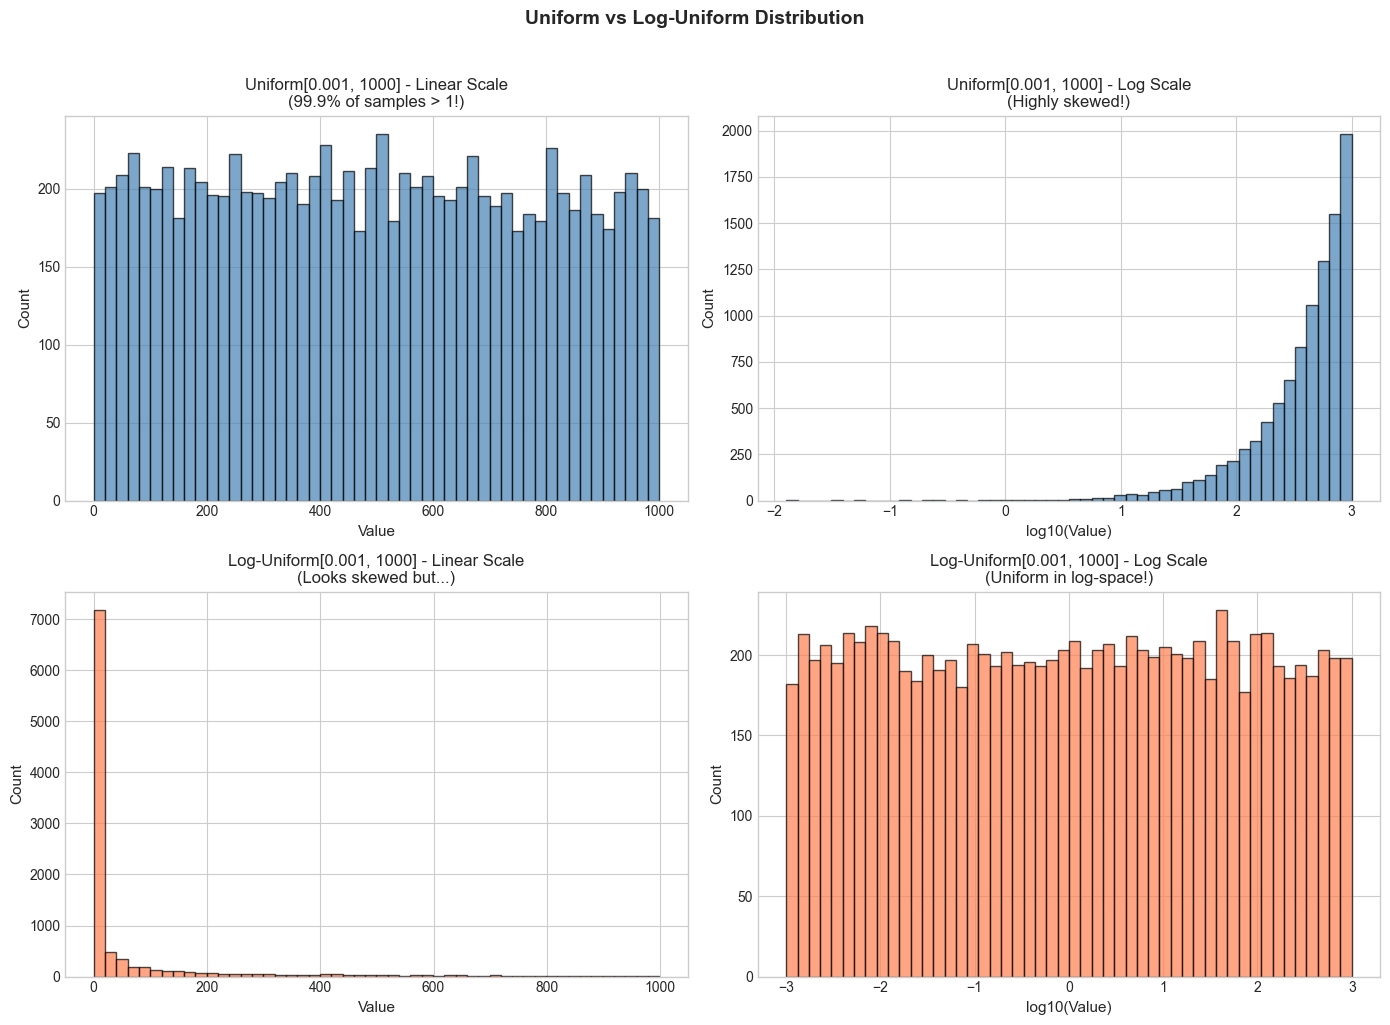

Distribution Statistics

Uniform[0.001, 1000.0]:
  Samples < 1: 16 (0.16%)
  Samples < 10: 95 (0.95%)

Log-Uniform[0.001, 1000.0]:
  Samples < 1: 4981 (49.81%)
  Samples < 10: 6678 (66.78%)


In [6]:
# Compare Uniform vs Log-Uniform sampling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

a, b = 1e-3, 1e3
n_samples_dist = 10000

# Uniform samples
uniform_samples = np.random.uniform(a, b, n_samples_dist)

# Log-uniform samples
log_uniform_dist = log_uniform(a=a, b=b)
log_uniform_samples = log_uniform_dist.rvs(size=n_samples_dist)

# Plot 1: Uniform distribution (linear scale)
ax1 = axes[0, 0]
ax1.hist(uniform_samples, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Value', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Uniform[0.001, 1000] - Linear Scale\n(99.9% of samples > 1!)', fontsize=12)

# Plot 2: Uniform distribution (log scale)
ax2 = axes[0, 1]
ax2.hist(np.log10(uniform_samples), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('log10(Value)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Uniform[0.001, 1000] - Log Scale\n(Highly skewed!)', fontsize=12)

# Plot 3: Log-uniform distribution (linear scale)
ax3 = axes[1, 0]
ax3.hist(log_uniform_samples, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Value', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Log-Uniform[0.001, 1000] - Linear Scale\n(Looks skewed but...)', fontsize=12)

# Plot 4: Log-uniform distribution (log scale)
ax4 = axes[1, 1]
ax4.hist(np.log10(log_uniform_samples), bins=50, color='coral', alpha=0.7, edgecolor='black')
ax4.set_xlabel('log10(Value)', fontsize=11)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('Log-Uniform[0.001, 1000] - Log Scale\n(Uniform in log-space!)', fontsize=12)

plt.suptitle('Uniform vs Log-Uniform Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Statistics
print("Distribution Statistics")
print("="*50)
print(f"\nUniform[{a}, {b}]:")
print(f"  Samples < 1: {(uniform_samples < 1).sum()} ({100*(uniform_samples < 1).mean():.2f}%)")
print(f"  Samples < 10: {(uniform_samples < 10).sum()} ({100*(uniform_samples < 10).mean():.2f}%)")
print(f"\nLog-Uniform[{a}, {b}]:")
print(f"  Samples < 1: {(log_uniform_samples < 1).sum()} ({100*(log_uniform_samples < 1).mean():.2f}%)")
print(f"  Samples < 10: {(log_uniform_samples < 10).sum()} ({100*(log_uniform_samples < 10).mean():.2f}%)")

In [7]:
# Verify log-uniformity with statistical test
from scipy.stats import kstest

# Test that log(samples) is uniformly distributed
log_samples = np.log(log_uniform_samples)
log_a, log_b = np.log(a), np.log(b)

# Kolmogorov-Smirnov test
ks_stat, p_value = kstest(log_samples, 'uniform', args=(log_a, log_b - log_a))

print("Kolmogorov-Smirnov Test for Log-Uniformity")
print("="*50)
print(f"H0: log(samples) ~ Uniform(log({a}), log({b}))")
print(f"\nKS Statistic: {ks_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"\nConclusion: {'Fail to reject H0 (log-uniform!)' if p_value > 0.05 else 'Reject H0'}")

Kolmogorov-Smirnov Test for Log-Uniformity
H0: log(samples) ~ Uniform(log(0.001), log(1000.0))

KS Statistic: 0.0068
P-value: 0.7446

Conclusion: Fail to reject H0 (log-uniform!)


## 4. Randomized Search with Purged CV

### When to Use Randomized Search

| Scenario | Grid Search | Randomized Search |
|----------|-------------|-------------------|
| Few parameters (2-3) | Preferred | OK |
| Many parameters (4+) | Intractable | Preferred |
| Continuous parameters | Requires discretization | Natural fit |
| Computational budget | Fixed by grid size | Controllable |

### Benefits of Randomized Search

1. **Controllable budget**: Set `n_iter` regardless of parameter space size
2. **Better coverage**: Irrelevant parameters don't waste iterations
3. **Continuous sampling**: Use distributions like log-uniform
4. **Often finds better solutions**: More efficient exploration

In [8]:
# Define parameter distributions for SVC
param_distributions_svc = {
    'C': log_uniform(a=1e-2, b=1e2),
    'gamma': log_uniform(a=1e-3, b=1e1),
}

print("Randomized Search Configuration")
print("="*50)
print(f"Estimator: SVC with RBF kernel")
print(f"\nParameter Distributions:")
print(f"  C: Log-Uniform[0.01, 100]")
print(f"  gamma: Log-Uniform[0.001, 10]")
print(f"\nIterations: 25")
print(f"CV folds: 5")
print(f"Total fits: 125")

Randomized Search Configuration
Estimator: SVC with RBF kernel

Parameter Distributions:
  C: Log-Uniform[0.01, 100]
  gamma: Log-Uniform[0.001, 10]

Iterations: 25
CV folds: 5
Total fits: 125


In [9]:
# Perform Randomized Search with Purged CV
print("Running Randomized Search with Purged K-Fold CV...")

start_time = time.time()

best_model_svc, best_params_svc, best_score_svc = randomized_search_cv(
    features=X,
    labels=y,
    label_times=label_times,
    estimator=SVC(kernel='rbf', probability=True, random_state=42),
    param_distributions=param_distributions_svc,
    n_iter=25,
    n_splits=5,
    embargo_pct=0.01,
    scoring='neg_log_loss',
    random_state=42,
    n_jobs=-1,
)

elapsed_time = time.time() - start_time

print(f"\nRandomized Search Complete!")
print("="*50)
print(f"Time elapsed: {elapsed_time:.2f} seconds")
print(f"\nBest Parameters:")
for param, value in best_params_svc.items():
    print(f"  {param}: {value:.6f}")
print(f"\nBest CV Score (neg_log_loss): {best_score_svc:.4f}")

Running Randomized Search with Purged K-Fold CV...



Randomized Search Complete!
Time elapsed: 3.02 seconds

Best Parameters:
  C: 5.456725
  gamma: 0.057625

Best CV Score (neg_log_loss): -0.4361


In [10]:
# Compare with Random Forest using randomized search
param_distributions_rf = {
    'n_estimators': int_log_uniform(a=10, b=500),
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
}

print("Running Randomized Search for Random Forest...")

start_time = time.time()

best_model_rf, best_params_rf, best_score_rf = randomized_search_cv(
    features=X,
    labels=y,
    label_times=label_times,
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions_rf,
    n_iter=30,
    n_splits=5,
    embargo_pct=0.01,
    scoring='neg_log_loss',
    random_state=42,
    n_jobs=-1,
)

elapsed_time = time.time() - start_time

print(f"\nRandomized Search Complete!")
print("="*50)
print(f"Time elapsed: {elapsed_time:.2f} seconds")
print(f"\nBest Parameters:")
for param, value in best_params_rf.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Score (neg_log_loss): {best_score_rf:.4f}")

Running Randomized Search for Random Forest...



Randomized Search Complete!
Time elapsed: 4.67 seconds

Best Parameters:
  max_depth: 15
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 231

Best CV Score (neg_log_loss): -0.4557


## 5. Scoring Metrics: Why neg_log_loss?

### The Problem with Accuracy

Accuracy treats all predictions equally, regardless of **confidence**:

| Prediction | True Label | Probability | Correct? | Accuracy Impact |
|------------|------------|-------------|----------|----------------|
| 1 | 1 | 0.51 | Yes | +1 |
| 1 | 1 | 0.99 | Yes | +1 (same!) |
| 1 | 0 | 0.51 | No | -1 |
| 1 | 0 | 0.99 | No | -1 (same!) |

### Why This Matters for Trading

In investment strategies:
- Position size often scales with **prediction confidence**
- A 99% confident wrong prediction causes **large losses**
- A 51% confident wrong prediction causes **small losses**

### Log Loss (Cross-Entropy) to the Rescue

Log loss penalizes confident wrong predictions more heavily:

$$L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{k=1}^{K} y_{n,k} \log(p_{n,k})$$

### When to Use Which Metric

| Application | Recommended Metric | Reason |
|-------------|-------------------|--------|
| Meta-labeling | `f1` | Handles class imbalance |
| Investment strategy | `neg_log_loss` | Considers confidence |
| Equal-weight positions | `accuracy` | Confidence doesn't matter |

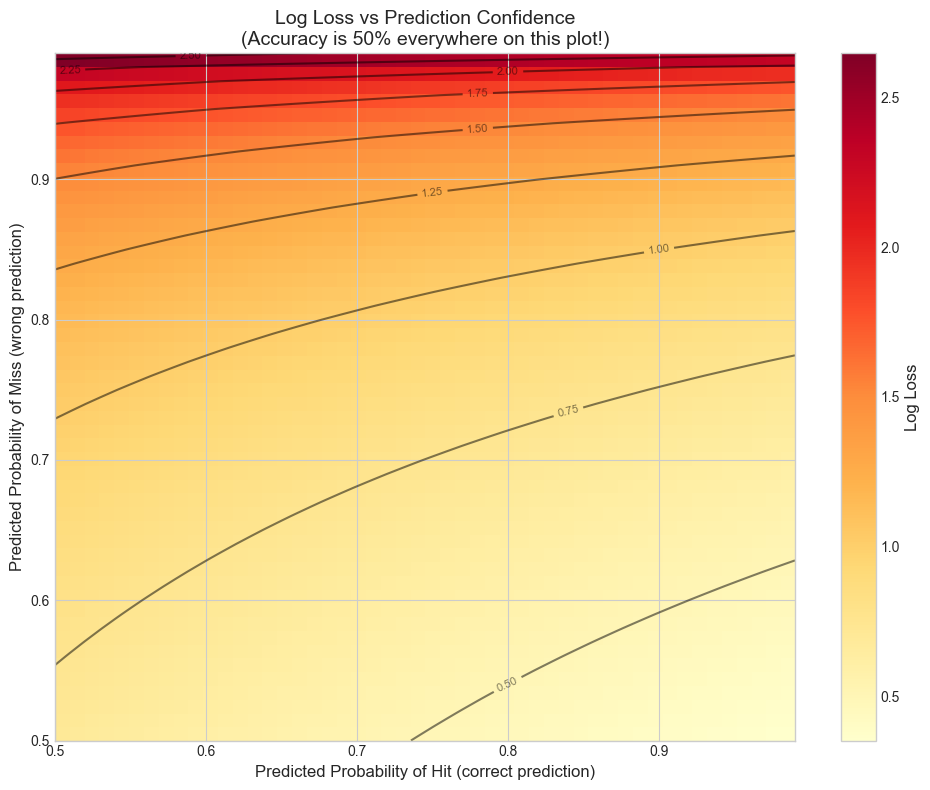

Key Insight:
- Top-right corner: High confidence in both predictions -> HIGH log loss
- Bottom-left corner: Low confidence in both predictions -> LOWER log loss
- Accuracy is 50% everywhere, but log loss varies from 0.5 to 2.3!


In [11]:
# Demonstrate the difference between accuracy and log loss
fig, ax = plt.subplots(figsize=(10, 8))

# Create a grid of probabilities
prob_hit = np.linspace(0.5, 0.99, 50)
prob_miss = np.linspace(0.5, 0.99, 50)
P_hit, P_miss = np.meshgrid(prob_hit, prob_miss)

# Compute log loss for 2 predictions: one hit (true=1, pred=1) and one miss (true=0, pred=1)
# Log loss = -[y*log(p) + (1-y)*log(1-p)]
# For hit (y=1): -log(p_hit)
# For miss (y=0, pred=1): -log(1-p_miss)
log_loss_grid = -0.5 * (np.log(P_hit) + np.log(1 - P_miss))

# Plot
im = ax.imshow(log_loss_grid, extent=[0.5, 0.99, 0.5, 0.99], origin='lower',
               aspect='auto', cmap='YlOrRd')

# Add contour lines
contours = ax.contour(P_hit, P_miss, log_loss_grid, levels=10, colors='black', alpha=0.5)
ax.clabel(contours, inline=True, fontsize=8, fmt='%.2f')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Log Loss', fontsize=12)

ax.set_xlabel('Predicted Probability of Hit (correct prediction)', fontsize=12)
ax.set_ylabel('Predicted Probability of Miss (wrong prediction)', fontsize=12)
ax.set_title('Log Loss vs Prediction Confidence\n(Accuracy is 50% everywhere on this plot!)', fontsize=14)

plt.tight_layout()
plt.show()

print("Key Insight:")
print("- Top-right corner: High confidence in both predictions -> HIGH log loss")
print("- Bottom-left corner: Low confidence in both predictions -> LOWER log loss")
print("- Accuracy is 50% everywhere, but log loss varies from 0.5 to 2.3!")

In [12]:
# Auto-selection of scoring metric
print("Automatic Scoring Metric Selection")
print("="*50)

# Binary labels (meta-labeling)
binary_y = np.array([0, 1, 0, 1, 0, 1, 0, 1])
print(f"\nBinary labels {set(binary_y)}:")
print(f"  -> {select_scoring_metric(binary_y)} (for meta-labeling)")

# Multi-class labels
multi_y = np.array([0, 1, 2, 0, 1, 2, 0, 1])
print(f"\nMulti-class labels {set(multi_y)}:")
print(f"  -> {select_scoring_metric(multi_y)} (considers confidence)")

# Binary labels with -1, 1 (not meta-labeling)
signed_y = np.array([-1, 1, -1, 1, -1, 1])
print(f"\nSigned labels {set(signed_y)}:")
print(f"  -> {select_scoring_metric(signed_y)} (not {0,1} so use log loss)")

Automatic Scoring Metric Selection

Binary labels {0, 1}:
  -> f1 (for meta-labeling)

Multi-class labels {0, 1, 2}:
  -> neg_log_loss (considers confidence)

Signed labels {1, -1}:
  -> neg_log_loss (not (0, 1) so use log loss)


## 6. Sample Weight Pipeline

### The Problem

Sklearn's `Pipeline.fit()` doesn't directly accept `sample_weight`. You must use:
```python
pipe.fit(X, y, clf__sample_weight=weights)  # Awkward!
```

### The Solution: SampleWeightPipeline

Our `SampleWeightPipeline` allows:
```python
pipe.fit(X, y, sample_weight=weights)  # Clean!
```

It automatically routes sample_weight to the final estimator.

In [13]:
# Create sample weights (e.g., based on return magnitude)
# More weight to recent observations (time decay)
sample_weights = np.linspace(0.5, 1.5, len(y))
sample_weights = sample_weights / sample_weights.sum()  # Normalize

print("Sample Weights (simulating return-weighted importance)")
print("="*50)
print(f"Min weight: {sample_weights.min():.6f}")
print(f"Max weight: {sample_weights.max():.6f}")
print(f"Sum: {sample_weights.sum():.6f}")

Sample Weights (simulating return-weighted importance)
Min weight: 0.000250
Max weight: 0.000750
Sum: 1.000000


In [14]:
# Create pipeline with StandardScaler and RandomForest
pipe = SampleWeightPipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

# Fit with sample weights - clean API!
pipe.fit(X, y, sample_weight=sample_weights)

print("SampleWeightPipeline Demo")
print("="*50)
print(f"Pipeline steps: {[name for name, _ in pipe.steps]}")
print(f"\nFit with sample_weight=... (clean API!)")
print(f"Training accuracy: {pipe.score(X, y):.4f}")

SampleWeightPipeline Demo
Pipeline steps: ['scaler', 'clf']

Fit with sample_weight=... (clean API!)
Training accuracy: 0.9110


In [15]:
# Compare with/without sample weights
from sklearn.model_selection import cross_val_score

# Without sample weights
pipe_no_weight = SampleWeightPipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])
pipe_no_weight.fit(X, y)

# With sample weights
pipe_with_weight = SampleWeightPipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])
pipe_with_weight.fit(X, y, sample_weight=sample_weights)

# Compare predictions on recent data (last 20%)
recent_idx = int(0.8 * len(y))
X_recent = X.iloc[recent_idx:]
y_recent = y[recent_idx:]

acc_no_weight = accuracy_score(y_recent, pipe_no_weight.predict(X_recent))
acc_with_weight = accuracy_score(y_recent, pipe_with_weight.predict(X_recent))

print("Comparison: With vs Without Sample Weights")
print("="*50)
print(f"\nAccuracy on recent data (last 20%):")
print(f"  Without weights: {acc_no_weight:.4f}")
print(f"  With weights:    {acc_with_weight:.4f}")
print(f"\nNote: Weighted model gives more importance to recent observations,")
print(f"which may improve performance on recent/future data.")

Comparison: With vs Without Sample Weights

Accuracy on recent data (last 20%):
  Without weights: 0.8525
  With weights:    0.9325

Note: Weighted model gives more importance to recent observations,
which may improve performance on recent/future data.


## 7. Comparing Search Methods

Let's compare Grid Search vs Randomized Search in terms of:
- Time taken
- Best score found
- Parameter coverage

In [16]:
# Grid Search for SVC (small grid)
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
}

print("Comparison: Grid Search vs Randomized Search")
print("="*60)

# Grid Search
print("\n1. Running Grid Search...")
start_time = time.time()
_, best_params_grid, best_score_grid = grid_search_cv(
    features=X,
    labels=y,
    label_times=label_times,
    estimator=SVC(kernel='rbf', probability=True, random_state=42),
    param_grid=param_grid_svc,
    n_splits=5,
    embargo_pct=0.01,
    scoring='neg_log_loss',
    n_jobs=-1,
)
grid_time = time.time() - start_time
grid_combinations = len(param_grid_svc['C']) * len(param_grid_svc['gamma'])

# Randomized Search (same budget)
print("2. Running Randomized Search...")
start_time = time.time()
_, best_params_rand, best_score_rand = randomized_search_cv(
    features=X,
    labels=y,
    label_times=label_times,
    estimator=SVC(kernel='rbf', probability=True, random_state=42),
    param_distributions=param_distributions_svc,
    n_iter=grid_combinations,  # Same number of evaluations
    n_splits=5,
    embargo_pct=0.01,
    scoring='neg_log_loss',
    random_state=42,
    n_jobs=-1,
)
rand_time = time.time() - start_time

print("\n" + "="*60)
print("Results")
print("="*60)
print(f"\n{'Metric':<30} {'Grid Search':<20} {'Randomized Search':<20}")
print("-"*70)
print(f"{'Combinations evaluated':<30} {grid_combinations:<20} {grid_combinations:<20}")
print(f"{'Time (seconds)':<30} {grid_time:<20.2f} {rand_time:<20.2f}")
print(f"{'Best CV Score':<30} {best_score_grid:<20.4f} {best_score_rand:<20.4f}")
print(f"{'Best C':<30} {best_params_grid['C']:<20} {best_params_rand['C']:<20.4f}")
print(f"{'Best gamma':<30} {best_params_grid['gamma']:<20} {best_params_rand['gamma']:<20.4f}")

Comparison: Grid Search vs Randomized Search

1. Running Grid Search...


2. Running Randomized Search...



Results

Metric                         Grid Search          Randomized Search   
----------------------------------------------------------------------
Combinations evaluated         25                   25                  
Time (seconds)                 3.24                 2.98                
Best CV Score                  -0.4338              -0.4361             
Best C                         100                  5.4567              
Best gamma                     0.01                 0.0576              


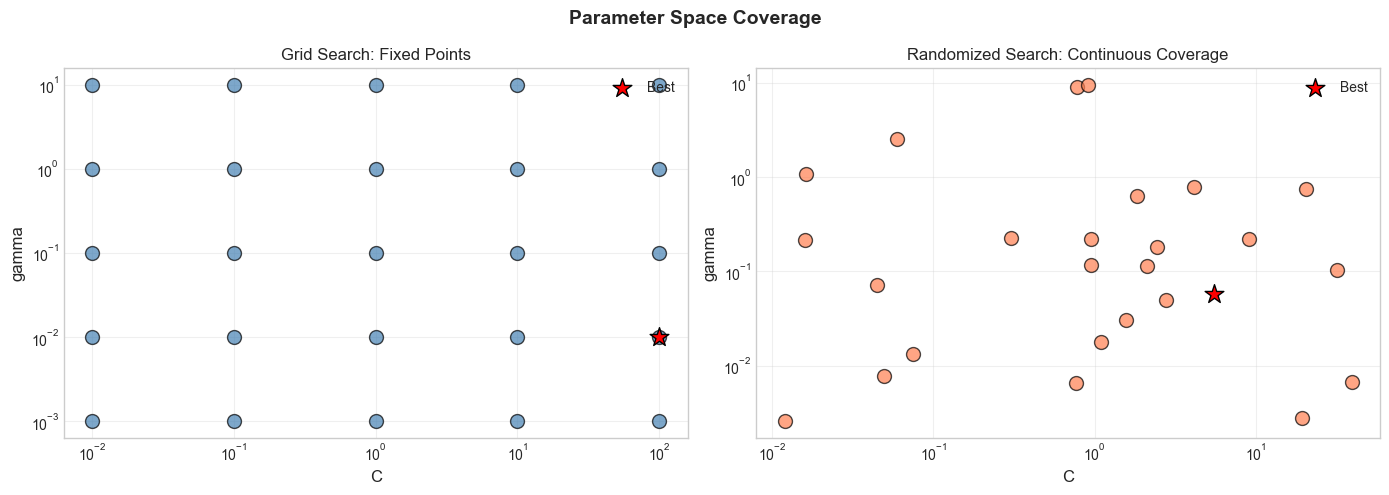

Grid Search: Limited to discrete points
Randomized Search: Can find optimal values between grid points!


In [17]:
# Visualize parameter coverage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grid Search coverage
ax1 = axes[0]
C_grid = param_grid_svc['C']
gamma_grid = param_grid_svc['gamma']
C_mesh, gamma_mesh = np.meshgrid(C_grid, gamma_grid)
ax1.scatter(C_mesh.flatten(), gamma_mesh.flatten(), s=100, c='steelblue', alpha=0.7, edgecolors='black')
ax1.scatter([best_params_grid['C']], [best_params_grid['gamma']], s=200, c='red', marker='*', 
            edgecolors='black', label='Best', zorder=5)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('C', fontsize=12)
ax1.set_ylabel('gamma', fontsize=12)
ax1.set_title('Grid Search: Fixed Points', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Randomized Search coverage
ax2 = axes[1]
# Generate 25 random samples to show
np.random.seed(42)
C_samples = log_uniform(1e-2, 1e2).rvs(size=grid_combinations)
gamma_samples = log_uniform(1e-3, 1e1).rvs(size=grid_combinations)
ax2.scatter(C_samples, gamma_samples, s=100, c='coral', alpha=0.7, edgecolors='black')
ax2.scatter([best_params_rand['C']], [best_params_rand['gamma']], s=200, c='red', marker='*',
            edgecolors='black', label='Best', zorder=5)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('C', fontsize=12)
ax2.set_ylabel('gamma', fontsize=12)
ax2.set_title('Randomized Search: Continuous Coverage', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Parameter Space Coverage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Grid Search: Limited to discrete points")
print("Randomized Search: Can find optimal values between grid points!")

## 8. Best Practices

### Summary of HPO Methods

| Method | Use When | Pros | Cons |
|--------|----------|------|------|
| **Grid Search** | Few params, discrete values | Exhaustive, reproducible | Exponential complexity |
| **Randomized Search** | Many params, continuous values | Controllable budget, better coverage | Slightly random |

### Recommended Scoring Metrics

| Application | Metric | Reason |
|-------------|--------|--------|
| Meta-labeling | `f1` | Handles imbalanced classes |
| Investment strategy | `neg_log_loss` | Penalizes confident errors |
| Equal-weight betting | `accuracy` | Confidence doesn't matter |

### Key Recommendations

1. **Always use Purged K-Fold CV** for financial data
2. **Use log-uniform** for parameters like C, gamma, learning_rate
3. **Use neg_log_loss** for strategies where position size depends on confidence
4. **Apply embargo** (1-5%) to handle serial correlation
5. **Consider bagging** the tuned estimator for robustness
6. **Use sample weights** to emphasize recent or high-return observations

In [18]:
# Final summary
print("HPO Tutorial Complete!")
print("="*60)
print("\nKey Takeaways:")
print()
print("1. ALWAYS USE PURGED CV for financial HPO")
print("   - Standard CV causes information leakage")
print("   - Results will be overly optimistic")
print("   - Model will fail in production")
print()
print("2. SCORING METRICS MATTER")
print("   - f1: for meta-labeling (imbalanced classes)")
print("   - neg_log_loss: for investment strategies")
print("   - accuracy: only if positions are equal-weighted")
print()
print("3. USE LOG-UNIFORM for scale-sensitive params")
print("   - C (SVC), gamma (RBF), learning_rate, etc.")
print("   - Uniform sampling is inefficient")
print()
print("4. RANDOMIZED SEARCH for large param spaces")
print("   - Controllable computational budget")
print("   - Often finds better solutions")
print()
print("Functions available in afml.hpo:")
print("  - grid_search_cv()")
print("  - randomized_search_cv()")
print("  - fit_hyperparameters()")
print("  - log_uniform(), int_log_uniform()")
print("  - SampleWeightPipeline")
print("  - select_scoring_metric()")

HPO Tutorial Complete!

Key Takeaways:

1. ALWAYS USE PURGED CV for financial HPO
   - Standard CV causes information leakage
   - Results will be overly optimistic
   - Model will fail in production

2. SCORING METRICS MATTER
   - f1: for meta-labeling (imbalanced classes)
   - neg_log_loss: for investment strategies
   - accuracy: only if positions are equal-weighted

3. USE LOG-UNIFORM for scale-sensitive params
   - C (SVC), gamma (RBF), learning_rate, etc.
   - Uniform sampling is inefficient

4. RANDOMIZED SEARCH for large param spaces
   - Controllable computational budget
   - Often finds better solutions

Functions available in afml.hpo:
  - grid_search_cv()
  - randomized_search_cv()
  - fit_hyperparameters()
  - log_uniform(), int_log_uniform()
  - SampleWeightPipeline
  - select_scoring_metric()
